In [79]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

Populating the interactive namespace from numpy and matplotlib


In [36]:
pacs = pd.read_csv('Campaign_Finance_data/pacs_all.csv', encoding = "ISO-8859-1")
conginvest = pd.read_csv('Goal1_PFD_1of3.csv', encoding = "ISO-8859-1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

I tried to join another dataset to use PAC Names instead of their PACID for clarity. However, many of the PACIDs have multiple organization names. I decided to work on the graph rather than data cleaning for this datadive.

In [37]:
cmte = pd.read_csv('Campaign_Finance_data/cmtes_all.csv', encoding = "ISO-8859-1")
pacs = pacs.merge(cmte[['CmteID', 'PACShort']], left_on='PACID', right_on='CmteID', how='left').drop('CmteID', axis=1)

temp = pacs[['Cycle','PACID','PACShort']].drop_duplicates()

print('Number of PACIDs with multiple organization names: ',
    len(temp.groupby(['Cycle','PACID'])['PACShort'].size().reset_index(). \
        query('PACShort > 1'))) #16723 

del temp, cmte

Number of PACIDs with multiple organization names:  16723


Next is the data processing. `conginvest` is a table with the number of congressional investments by industry code. `pacs` is updated to use less columns.

In [38]:
# RealCodeOut is congresspeople investing
# RealCodeIn is industry giving money to congresspeople
conginvest = conginvest[['CID', 'RealCode']].rename(columns={'RealCode':'RealCodeOut'}). \
    groupby(['CID','RealCodeOut']).size().reset_index(name='NumInvestments')
pacs = pacs[['Cycle', 'CID', 'PACID', 'Amount', 'RealCode']].rename(columns={'RealCode':'RealCodeIn'})

In [39]:
# Table of PAC contributions by industry code and to which congressperson
contributions = pacs. \
    groupby(['PACID', 'RealCodeIn', 'CID'])['Amount']. \
    sum().reset_index()

print(len(contributions))
contributions.head()

920282


,PACID,RealCodeIn,CID,Amount
0,C00000026,H1500,N00000209,2500
1,C00000026,H1500,N00000659,5000
2,C00000026,H1500,N00000756,42630
3,C00000026,H1500,N00000817,2500
4,C00000026,H1500,N00001022,500


In [40]:
# merge conginvest with contributions to have all the data in one table
df = contributions.merge(conginvest, 
                         left_on=['CID','RealCodeIn'], right_on=['CID','RealCodeOut'], how='left'). \
                        drop('RealCodeOut', axis=1). \
                        rename(columns={'RealCodeIn': 'RealCode'})
df.dropna().head()

,PACID,RealCode,CID,Amount,NumInvestments
78,C00000042,M2300,N00000561,162500,19.0
87,C00000042,M2300,N00001489,45500,1.0
99,C00000042,M2300,N00002097,13000,4.0
103,C00000042,M2300,N00002315,52000,10.0
105,C00000042,M2300,N00002328,26000,5.0


This is the final table used in the graph. I bring the data to the industry level because there were far too many PACs to effectively graph the network.

In [41]:
industry_df = df.groupby(['RealCode', 'CID'])['Amount', 'NumInvestments']. \
    sum().reset_index()

industry_df.dropna().head()

,RealCode,CID,Amount,NumInvestments
21,A0000,N00004645,6000,3.0
29,A0000,N00005559,31000,6.0
31,A0000,N00006263,12000,2.0
108,A1000,N00001329,52000,1.0
113,A1000,N00001510,91000,9.0


# Creating the Graph

Here I use a subset of the industry dataset to build the graph and cleanly show results. As we increase the data, the graph becomes increasingly more dense and requires zooming to see any of the data.

In [42]:
industry_subset = pd.DataFrame(industry_df.dropna()[:50])

G = nx.from_pandas_dataframe(industry_subset, 'RealCode', 'CID', ['Amount', 'NumInvestments'])

In [43]:
# small function to allow people to quickly identify investments between a specific industry and congressperson

def connections(industry, congressperson):
    print(industry + ' has invested $',
      G[industry][congressperson]['Amount'],
      'in ' + congressperson+ ', and ' + congressperson + ' has made',
      G[industry][congressperson]['NumInvestments'],
      'investments in ' + industry)

connections('A0000','N00005559')

A0000 has invested $ 31000 in N00005559, and N00005559 has made 6.0 investments in A0000


In [47]:
node_size = industry_subset.groupby('RealCode')['Amount'].sum().to_dict()

temp = industry_subset.groupby('CID')['Amount'].sum().to_dict()
for key, value in temp.items(): temp[key] = 0
node_size.update(temp)
del temp

nx.set_node_attributes(G, node_size, 'size')

G.nodes()

NodeView(('A0000', 'N00004645', 'N00005559', 'N00006263', 'A1000', 'N00001329', 'N00001510', 'N00001758', 'N00002091', 'N00002269', 'N00002315', 'N00002383', 'N00002743', 'N00002877', 'N00003028', 'N00003062', 'N00003254', 'N00003288', 'N00003675', 'N00003682', 'N00003709', 'N00004208', 'N00004227', 'N00004436', 'N00004484', 'N00004558', 'N00004698', 'N00004781', 'N00004905', 'N00005165', 'N00005178', 'N00005195', 'N00005244', 'N00005282', 'N00005353', 'N00005455', 'N00006060', 'N00006283', 'N00007099', 'N00007248', 'N00008032', 'N00008092', 'N00009888', 'N00009954', 'N00012586', 'N00013131', 'N00013323', 'N00025054', 'N00026041'))

# Visualizing the Graph

Below is the code to visualize the graph. A few key notes:

- The larger nodes are industries, and the smaller nodes are congresspeople
- The closer a congressperson is to an industry, the greater amount of money the industry has invested in that congressperson
- Edge colors represent the number of investments a congressperson has made in that industry. Blue is a smaller amount, whereas red is a larger amount. The number of investments is also annotated on each edge.

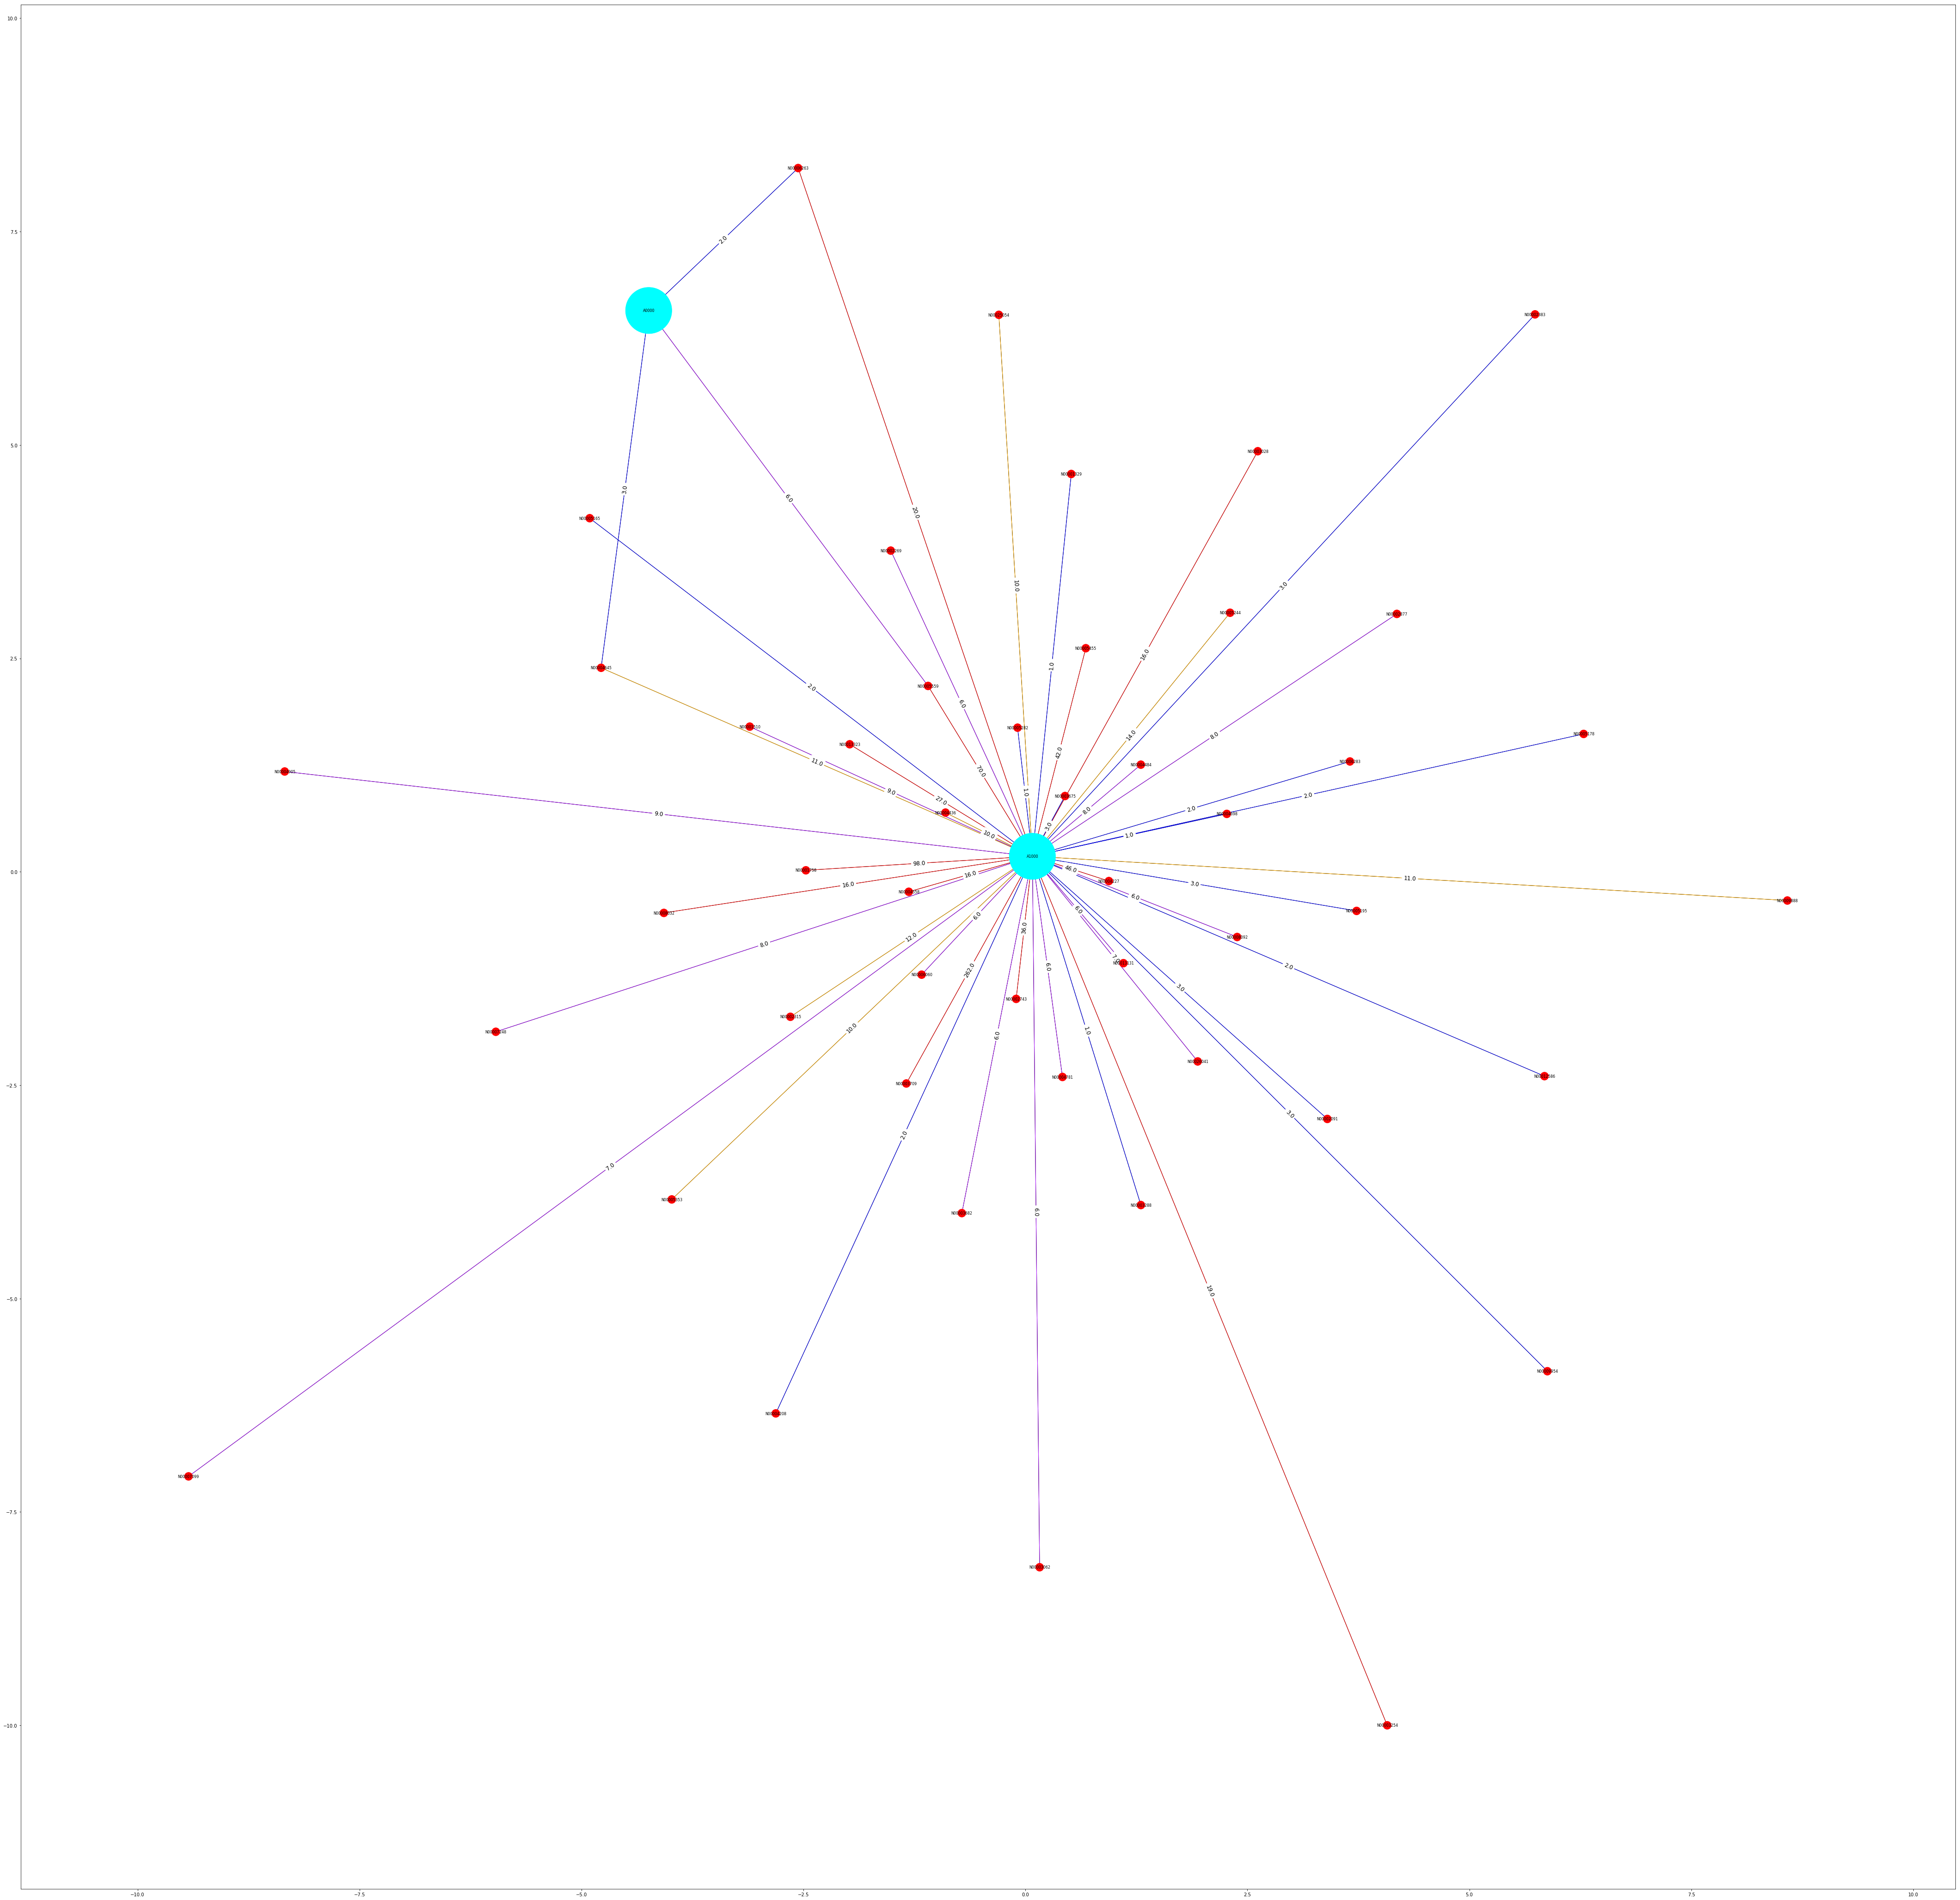

In [80]:
# initialize the graph
pos = nx.spring_layout(G, scale=10, weight='Amount', k=10)
plt.figure(figsize=(75,75))


# modify node size and color
nodes = G.nodes()
sizes = [nodes[i]['size'] for i in nodes]
node_colors = [nodes[i] for i in nodes]
for i in range(len(sizes)):
    if sizes[i] < 1:
        sizes[i] = 300
        node_colors[i] = 'red'
    else:
        sizes[i] = 10000
        node_colors[i] = 'cyan'

nx.draw_networkx(G, pos,
                font_size=8,
                node_size=sizes,
                node_color=node_colors)


# add edge colors
edges = G.edges()
colors = [G[u][v]['NumInvestments'] for u,v in edges]
for i in range(len(colors)):
    if colors[i]<5:
        colors[i] = '#0000ff' #blue
    elif colors[i]<10:
        colors[i] = '#ab0fff' #purple
    elif colors[i]<15:
        colors[i] = '#ffae00' #orange
    else:
        colors[i] = '#ff0000' #red


weights = [G[u][v]['Amount'] for u,v in edges]
# decided not to use weights because it makes it harder to
# use the number of nodes we have

nx.draw_networkx_edges(G, pos, edge_color = colors)#, width=log(weights))


# add edge labels
edge_labels = nx.get_edge_attributes(G,'NumInvestments')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=12)

# save the graph as a pdf
plt.savefig('mini-graph.pdf', dpi=800)

In [26]:
# save the whole graph (not subset) as a gpickle for easy distribution
H = nx.from_pandas_dataframe(industry_df, 'RealCode', 'CID', ['Amount', 'NumInvestments'])
node_size = industry_df.groupby('RealCode')['Amount'].sum().to_dict()

temp = industry_df.groupby('CID')['Amount'].sum().to_dict()
for key, value in temp.items(): temp[key] = 0
node_size.update(temp)
del temp

nx.set_node_attributes(H, node_size, 'TotalDonations')

nx.write_gpickle(H,"NetworkxGraph.gpickle")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [53]:
connections('A1000','N00003709')

A1000 has invested $ 123500 in N00003709, and N00003709 has made 262.0 investments in A1000


In [86]:
def plotgraph(dataset, industry_name):
    
    dataset_subset = pd.DataFrame(dataset.dropna().query('RealCode == @industry_name'))

    graph = nx.from_pandas_dataframe(dataset_subset, 'RealCode', 'CID', ['Amount', 'NumInvestments'])
    
    node_size = dataset_subset.groupby('RealCode')['Amount'].sum().to_dict()

    temp = dataset_subset.groupby('CID')['Amount'].sum().to_dict()
    for key, value in temp.items(): temp[key] = 0
    node_size.update(temp)
    del temp

    nx.set_node_attributes(graph, node_size, 'TotalDonations')

    
    # initialize the graph
    pos = nx.spring_layout(graph, scale=5, weight='Amount', k=15)
    plt.figure(figsize=(75,75))

    # modify node size and color
    nodes = graph.nodes()
    sizes = [nodes[i]['TotalDonations'] for i in nodes]
    node_colors = [nodes[i] for i in nodes]
    for i in range(len(sizes)):
        if sizes[i] < 1:
            sizes[i] = 200
            node_colors[i] = 'red'
        else:
            sizes[i] = 2000
            node_colors[i] = 'cyan'

    nx.draw_networkx(graph, pos,
                    font_size=8,
                    node_size=sizes,
                    node_color=node_colors)


    # add edge colors
    edges = graph.edges()
    colors = [graph[u][v]['NumInvestments'] for u,v in edges]
    for i in range(len(colors)):
        if colors[i]<5:
            colors[i] = '#0000ff' #blue
        elif colors[i]<10:
            colors[i] = '#ab0fff' #purple
        elif colors[i]<15:
            colors[i] = '#ffae00' #orange
        else:
            colors[i] = '#ff0000' #red

    nx.draw_networkx_edges(graph, pos, edge_color = colors)#, width=log(weights))


    # add edge labels
    edge_labels = nx.get_edge_attributes(graph,'NumInvestments')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels = edge_labels, font_size=12)

    # save the graph as a pdf
    plt.savefig("%sgraph.pdf" % industry_name)
    return plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

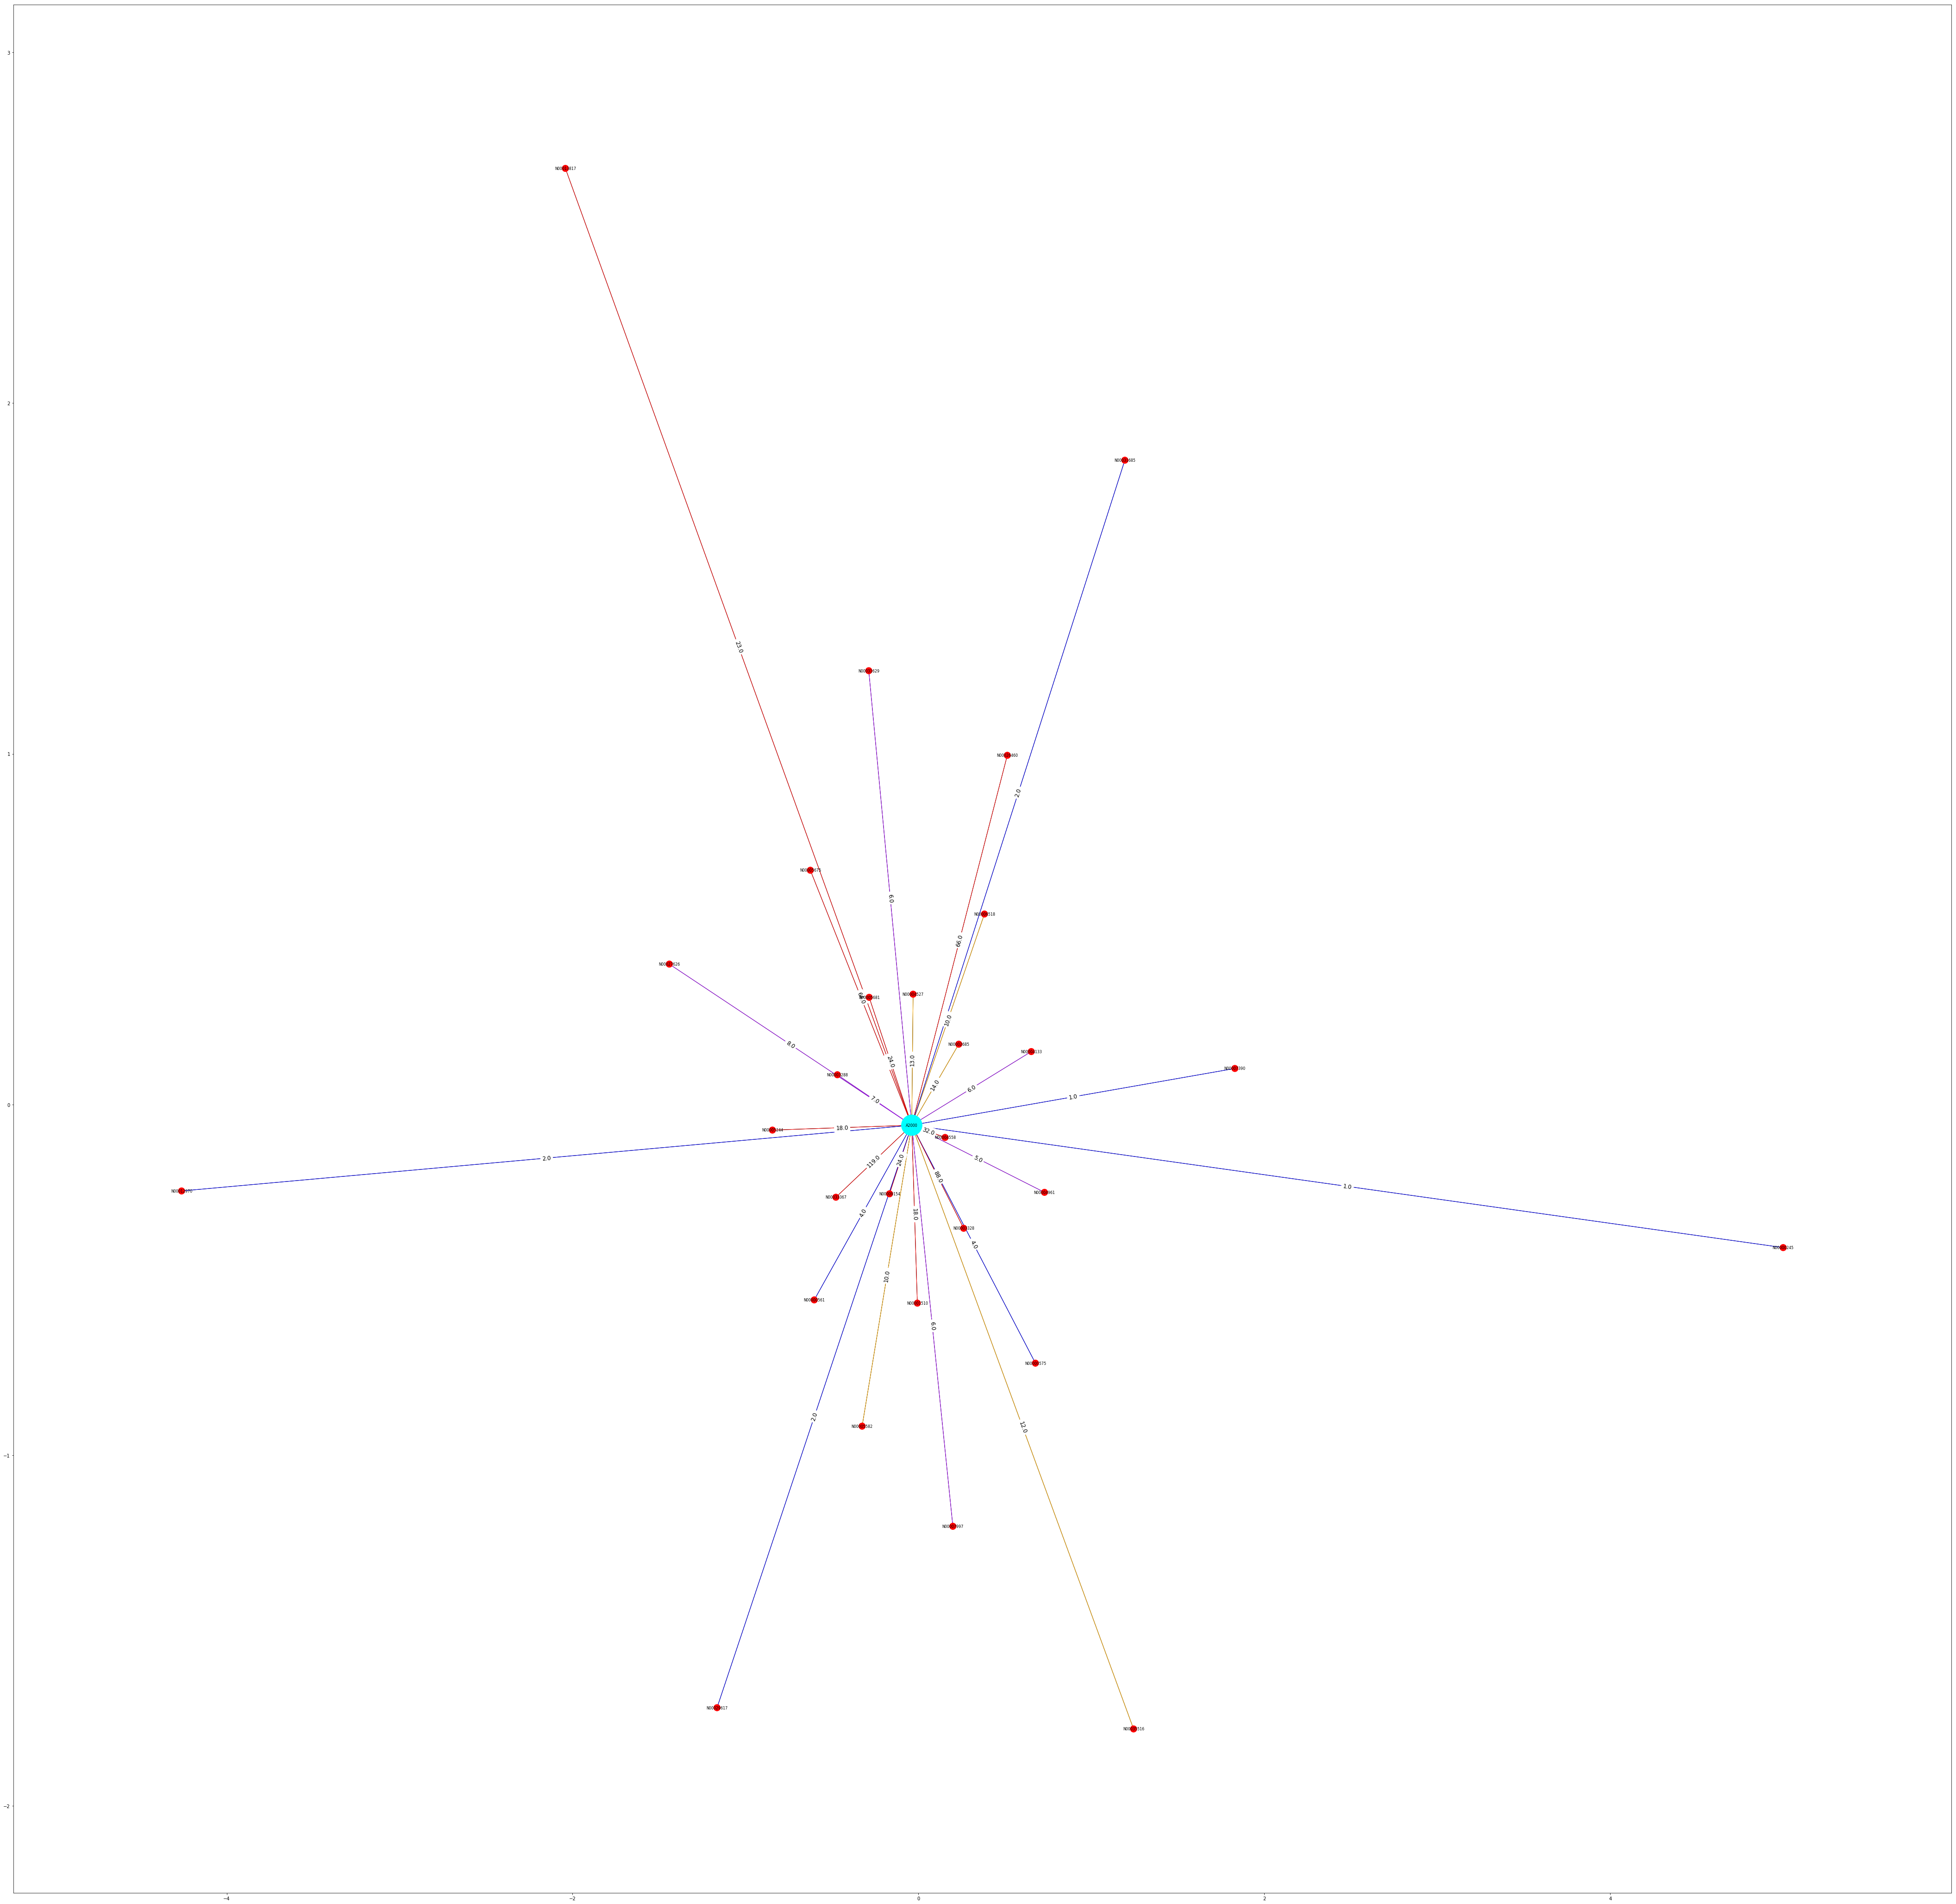

In [87]:
plotgraph(industry_df,'A2000')